In [3]:
import time
print(time.ctime())

Mon Nov 20 15:21:48 2017


<sub>Bei diesem IPython-Notebook handelt es sich um eine Beispiel-Rechnung als Ergänzung zur Dissertationsschrift von C. Knoll. Allgemeine Hinweise zu den Beispielen sind in der [readme.md-Datei des entsprechenden Repositoriums](https://github.com/cknoll/beispiele/blob/master/readme.md) zu finden.</sub>

---

**Betrachtetes System**: aktuiertes Pendel, dessen Aufhängepunkt an einem horizontal verschieblichen Wagen hängt, der elastisch mit einem aktuierten Wagen verbunden ist.


Bild stimmt nicht mehr!!

<img src="files/images/pendel_wagen_feder_wagen.png">

**Betrachtete Aspekte**:

* Ist das System statisch Eingangs-Zustands-Linearisierbar.
  * Wenn ja, wie sieht ein entsprechender linearisierender Ausgang aus?

* Wie ist die Situation, wenn ein "intuitiver" flacher Ausgang (Absolutkoordinaten des Pendelschwerpunkts) untersucht wird?

* Flachheitsbasierte Trajektorienplanung


[//]: # (custom_config_start)
$$
\newcommand{\col}{\mathrm{col}}
\newcommand{\bs}{\boldsymbol}
\newcommand{\y}{\bs y}
\newcommand{\nx}{n_{\boldsymbol x}}
\newcommand{\Ddt}{\left(\tfrac{d}{dt}\right)}
$$
[//]: # (custom_config_end)



In [5]:
%load_ext ipydex.displaytools
%matplotlib inline

import sympy as sp
from sympy import sin, cos, pi
from sympy.interactive import printing
import symbtools as st
import scipy.integrate as sc_integrate
import matplotlib.pyplot as pl

import symbtools.modeltools as mt


printing.init_printing(1)

In [6]:
t = sp.Symbol('t')
np = 0
nq = 2
n = np + nq
pp = st.symb_vector("p1:{0}".format(np+1))
qq = st.symb_vector("q1:{0}".format(nq+1))

aa = st.symb_vector("a1:{0}".format(nq+1))

ttheta = st.row_stack(pp, qq) ##:T
tthetad = st.time_deriv(ttheta, ttheta) ##:T
tthetadd = st.time_deriv(ttheta, ttheta, order=2) ##:T
st.make_global(ttheta, tthetad, tthetadd)

---


---


---


In [7]:
params = sp.symbols('s3, m2, m3, g')
st.make_global(params)

tau1, tau2 = ttau = st.symb_vector("tau1, tau2")

### Festlegung der Geometrie des mechanischen Systemes

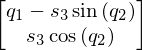

---


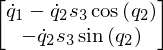

---


In [9]:
#Einheitsvektoren

ex = sp.Matrix([1,0])
ey = sp.Matrix([0,1])


# Koordinaten der Schwerpunkte und Gelenke
S2 = ex*q1 # Schwerpunkt K2
G3 = S2 # Gelenk

# Schwerpunkt des Pendels #zeigt nach oben
S3 = G3 + mt.Rz(q2)*ey*s3 ##:

# Zeitableitungen der Schwerpunktskoordinaten
Sd2, Sd3  = st.col_split(st.time_deriv(st.col_stack(S2, S3), ttheta)) ##

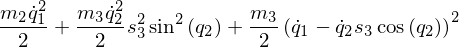

---


---


In [10]:
# Energie

T_rot = 0 # Pendel as mathematisches Pendel angenommen
T_trans = ( m2*Sd2.T*Sd2 + m3*Sd3.T*Sd3 )/2

T = T_rot + T_trans[0] ##:
V = m3*g*S3[1] ##:

In [11]:
external_forces = [tau1, tau2]
assert not any(external_forces[:np])
mod = mt.generate_symbolic_model(T, V, ttheta, external_forces)

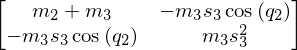

In [12]:
# Massenmatrix
mod.MM

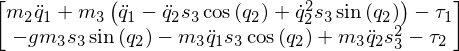

In [13]:
mod.eqns

In [16]:
mod.calc_state_eq()

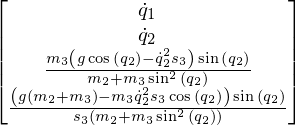

___


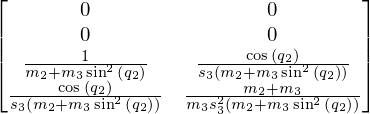

___


In [18]:
mod.f ##:

mod.g ##:

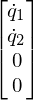

---


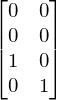

---


---


In [19]:
# partiell linearisierte Gleichungen (hier: partiell=vollständig)
mod.calc_coll_part_lin_state_eq()

f = mod.ff ##:
G = mod.gg ##:
g1, g2 = st.col_split(G)

xx = mod.x ##:T

## Überprüfung auf statische Eingangs-Zustands-Linearisierbarkeit

Konstrunktion der Distributionen $\Delta_k$

In [23]:
nx = len(xx)

# Liste der Distributionen
# (mit Eingangsvektorfeldern starten (Delta_0 = G) )
Delta_list = [mod.g]

for k in range(1, nx):
    Delta_j_full = Delta_list[-1]
    Delta_j = Delta_j_full[:, -nq:]# nur die letzten nq Spalten für Lieklammer relevant
    Delta_k = []
    for vf in st.col_split(Delta_j):
        Delta_k.append(st.lie_bracket(mod.f, vf, xx))
    
    # neu berechnete VF zusammen mit bisherigen in Matrix konvertieren
    Delta_k = st.col_stack(Delta_j_full, *Delta_k)
    Delta_list.append(Delta_k)

In [24]:
for i, D in enumerate(Delta_list):
    print("dim(Delta_%i) =" %i, st.rnd_number_rank(D))
    
    # failing_vf enthält die ersten beiden VF, deren Lie-Klammer nicht in der Distribution liegen
    inv_flag, failing_vf = st.involutivity_test(D, xx)
    print("Delta_%i involutiv? %s\n" %(i, inv_flag))

dim(Delta_0) = 2
Delta_0 involutiv? True

dim(Delta_1) = 4
Delta_1 involutiv? True

dim(Delta_2) = 4
Delta_2 involutiv? True

dim(Delta_3) = 4
Delta_3 involutiv? True



### Fazit:
Das System ist also statisch Eingangs-Zustands-Linearisierbar.

---

Überprüfung: wird durch die Absolutkoordinaten des Pendelschwerpunkts ein in statisch linearisierender Ausgang gebildet (d.h. hat dieser Ausgang einen wohldefinierten und vollständigen relativen Grad?):

In [27]:
h1, h2 = S3

Funktion definieren, die $L_{\bs g_i}L_{\bs f}^k h(\bs x)$ in Abhängigkeit von $h, i$ und $k$ berechnet

In [28]:
def LgLf(h, i, k):
    """
    h:    Skalarfeld
    i:    Index für Eingangsvektorfeld
    k:    Ordnung der Lieableitung bezüglich k
    """
    Lf = st.lie_deriv(h, mod.f, xx, n=k)
    res = st.lie_deriv(Lf, mod.g[:, i], xx)
    return res.simplify()

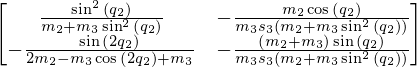

In [33]:
sp.Matrix([[LgLf(h1, i=0, k=1), LgLf(h1, i=1, k=1)],
           [LgLf(h2, i=0, k=1), LgLf(h2, i=1, k=1)]])

Für $q_2 \neq 0$ usw. ist diese Matrix regulär. D.h. $\y$ hat bis auf Singularitäten den vektoriellen relativen Grad $(2, 2)^T$